In [25]:
%pip install fastf1
%pip install scikit-learn
%pip install pandas
%pip install joblib
%pip install tdqm

In [26]:
import numpy as np
import pandas as pd

import argparse

import fastf1 as f1
from fastf1.core import Laps

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error

## Define functions

### Clean driver names

In [27]:
def clean_driver_name(driver_name: str) -> str:
    """
    Clean driver names by removing any unwanted characters and handling specific variations.
    """
    if pd.isna(driver_name):
        return driver_name
    cleaned_name = (driver_name.replace('.', '').replace('-', ' ').strip()
                    .replace('Ã©', 'é').replace('Ã¶', 'ö'))

    # Use a dictionary for specific driver name mappings
    name_mapping = {
        'Andrea Kimi Antonelli': 'Kimi Antonelli',
        'Kimi Andrea Antonelli': 'Kimi Antonelli', # Add another possible variation
        'Liam Lawson': 'Liam Lawson', # Explicit mapping
        'Yuki Tsunoda': 'Yuki Tsunoda', # Explicit mapping
        # Add more mappings here if other variations are found
    }

    # Check if the cleaned name is in the mapping, otherwise return the cleaned name
    return name_mapping.get(cleaned_name, cleaned_name)

### Non-ambiguous format for each session at each GP
(ie. "Dutch Grand Prix:FP1", "Dutch Grand Prix:Q", "Dutch Grand Prix:R")

In [28]:
def session_key(grand_prix: str, session_name: str):
    return f"{grand_prix}:{session_name}"

### Safe division
(if division by 0 then return np.nan to not damage dataframe)

In [29]:
def safe_div(a, b):
    """
    Return np.nan if division by zero
    """
    try:
        return float(a) / float(b) if (b not in [0, None, np.nan]) else np.nan
    except:
        return np.nan

### Load past race results to account for in ML model

In [30]:
def load_past_race_results(year: int, gp_name: str) -> pd.DataFrame:
    """
    Load past race results for a given year and grand prix name.
    """
    ses = f1.get_session(year, gp_name, 'R')
    ses.load(laps=True, telemetry=False, weather=False)
    res = ses.results

    print("\n--- Columns in past race results ---")
    print(res.columns)

    # Check if essential columns exist before proceeding
    required_cols = ['FullName', 'TeamName', 'Position', 'Status']
    if not all(col in res.columns for col in required_cols):
        print(f"Missing essential columns in race results for {gp_name}. Available columns: {res.columns.tolist()}")
        return pd.DataFrame(columns=['Driver', 'Team', 'Position', 'Status'])

    res = res.assign(Driver=res['FullName'].apply(clean_driver_name),
                     Team=res['TeamName'])

    # Select only relevant columns to avoid issues with missing columns later
    return res[['Driver', 'Team', 'Position', 'Status']]

### Load data for qualifying session results **to account for grid positions** (once available)

In [31]:
def load_qualifying_results(year: int, gp_name: str) -> pd.DataFrame:
    """
    Load qualifying results for the Dutch Grand Prix (once available).
    """
    try:
        ses = f1.get_session(year, gp_name, 'Q')
        ses.load(laps=True, telemetry=False, weather=False)
        q = ses.results.copy()

        # Check if essential columns exist before proceeding
        required_cols = ['FullName', 'TeamName', 'GridPosition']
        if not all(col in q.columns for col in required_cols):
            print(f"Missing essential columns in qualifying results for {gp_name}. Available columns: {q.columns.tolist()}")
            return pd.DataFrame(columns=['Driver', 'Team', 'GridPosition'])


        q = q.assign(Driver=q['FullName'].apply(clean_driver_name),
                    Team=q['TeamName'],
                    GridPosition=pd.to_numeric(q['GridPosition'], errors='coerce'))

        return q[['Driver', 'Team', 'GridPosition']]
    except Exception as e:
        print(f"Error loading qualifying results for {gp_name}: {e}")
        return pd.DataFrame(columns=['Driver', 'Team', 'GridPosition'])

### Load Free Practice Sessions (FP1, FP2, FP3)

In [32]:
def load_practice_features(year: int, gp_name: str) -> pd.DataFrame:
    """
    Load practice data for a given year and grand prix name.

    Args:
        year: The year of the race.
        gp_name: The name of the grand prix.

    Returns:
        A pandas DataFrame containing the practice data.
    """
    features = []
    for fp in ['FP1', 'FP2', 'FP3']:
        try:
            ses = f1.get_session(year, gp_name, fp)
            ses.load(laps=True, telemetry=False, weather=False)
            laps = ses.laps

            # Skip if no laps are available
            if laps is None or len(laps) == 0:
                continue

            # We only want representative laps
            good = laps.pick_quicklaps()
            if len(good) == 0:
                continue

            g_laps = (good.groupby(['Driver', 'Team'])
                      .agg(**{
                          f'{fp}_meanLapTime': ('LapTime', lambda s: pd.to_timedelta(s).dt.total_seconds().mean() if len(s) else np.nan),
                          f'{fp}_medianLapTime': ('LapTime', lambda s: pd.to_timedelta(s).dt.total_seconds().median() if len(s) else np.nan),
                          f'{fp}_fastestLap': ('LapTime', lambda s: pd.to_timedelta(s).dt.total_seconds().min() if len(s) else np.nan),
                          f'{fp}_numLaps': ('LapTime', 'size'),
                      })
                      .reset_index())

            features.append(g_laps)

        except Exception as e: # FP might not be available yet
            continue


    if not features:
        return pd.DataFrame(columns=['Driver', 'Team', 'FP1_meanLapTime', 'FP1_medianLapTime', 'FP1_fastestLap', 'FP1_numLaps',
                                     'FP2_meanLapTime', 'FP2_medianLapTime', 'FP2_fastestLap', 'FP2_numLaps',
                                     'FP3_meanLapTime', 'FP3_medianLapTime', 'FP3_fastestLap', 'FP3_numLaps'])

    # Merge all features into a single DataFrame
    feat = None
    for df in features:
        if feat is None:
            feat = df
        else:
            feat = pd.merge(feat, df, on=['Driver', 'Team'], how='outer')

    return feat

### Build season table of per-driver features leading to Dutch GP

In [33]:
def build_season_table(year: int, up_to_gp_name: str) -> pd.DataFrame:
    """
    Build a season table of per-driver features leading but up to the specified Grand Prix.
    """
    schedule = f1.get_event_schedule(year)

    # Use the hardcoded list of Grand Prix
    grand_prix_list = [
        "Australian Grand Prix",
        "Chinese Grand Prix",
        "Japanese Grand Prix",
        "Bahrain Grand Prix",
        "Saudi Arabian Grand Prix",
        "Miami Grand Prix",
        "Emilia Romagna Grand Prix",
        "Monaco Grand Prix",
        "Spanish Grand Prix",
        "Canadian Grand Prix",
        "Austrian Grand Prix",
        "British Grand Prix",
        "Belgian Grand Prix",
        "Hungarian Grand Prix"
    ]

    # Load data for each of the previous completed races
    rows = []

    for gp in grand_prix_list:
        try:
            ses_race = f1.get_session(year, gp, 'R')
            ses_race.load(laps=True, telemetry=False, weather=False)
            res = ses_race.results

            # Check if essential columns exist before proceeding
            required_cols = ['FullName', 'TeamName', 'Position', 'Status', 'GridPosition']
            if not all(col in res.columns for col in required_cols):
                print(f"Missing essential columns in race results for {gp}. Available columns: {res.columns.tolist()}")
                continue

            df = res.assign(Driver=res['FullName'].apply(clean_driver_name),
                            Team=res['TeamName'])

            df['Position'] = pd.to_numeric(df['Position'], errors='coerce')
            df['finish_ok'] = (~df['Status'].fillna('').str.contains('Retired|Disqualified|Not Classified|Did Not Finish', case=False)).astype(int)
            df['grid_pos'] = pd.to_numeric(df['GridPosition'], errors='coerce') # Use GridPosition directly

            df['GP'] = gp
            df['Date'] = ses_race.date # Add event date for chronological sorting
            rows.append(df[['Driver', 'Team', 'GP', 'Date', 'Position', 'Status', 'finish_ok', 'grid_pos']]) # Select relevant columns

        except Exception as e:
            print(f"An error occurred while processing data for {gp}: {e}")
            continue
    if not rows:
        raise RuntimeError("Could not assemble any past race results. Try a different year or check FastF1 availability.")

    hist = pd.concat(rows, ignore_index=True)
    # hist = hist.sort_values(by=['Driver', 'Date']).reset_index(drop=True) # Remove sorting from here, will sort in build_training_data

    # Aggregate data by driver and GP
    agg = (hist.groupby(['Driver', 'Team'])
           .agg(
               num_races = ('GP', 'size'),
               mean_finish_pos = ('Position', 'mean'),
               median_finish_pos = ('Position', 'median'),
               best_finish_pos = ('Position', 'min'),
               finish_rate = ('finish_ok', 'mean'),
               mean_grid_pos = ('grid_pos', 'mean'),
               median_grid_pos = ('grid_pos', 'median'),
           )
           .reset_index())

    # Normalise feature scale using log transforms
    agg['form_score'] = (1/agg['mean_finish_pos']).replace([np.inf, -np.inf], np.nan)  # Invert finish position
    agg['qual_form'] = (1/agg['mean_grid_pos']).replace([np.inf, -np.nan], np.nan)  # Invert grid position

    return agg, hist

## Training

### Build training data function
(labeled dataset from past races the model will learn from)

In [34]:
def build_training_data(season_agg: pd.DataFrame, hist: pd.DataFrame, mode: str, free_practice: pd.DataFrame) -> pd.DataFrame:
    """
    One training row per (driver, past race) with features form season to date

    Args:
        season_agg: A pandas DataFrame containing the aggregated data for the current season.
        hist_data: A pandas DataFrame containing the historical data for the previous seasons.
    """

    hist_sorted = hist.sort_values(by=['Driver', 'Date']).copy() # Sort by Driver and Date
    feats = []
    driver_groups = hist_sorted.groupby('Driver')

    for driver, group in driver_groups:
        group = group.reset_index(drop=True)
        for i in range(len(group)):
            row = group.iloc[i]

            # Calculate statistics based on all races *up to and including* the current race
            races_up_to_current = group.iloc[:i+1]

            if len(races_up_to_current) == 0:
                continue

            tmp = {
                'Driver': driver,
                'Team': row['Team'],
                'GP': row['GP'],
                'y_finish_pos': row['Position'], # To be predicted!!!

                # stats up to and including the current race
                'num_races': len(races_up_to_current), # Count of races *up to and including* the current one
                'mean_finish_up_to_current': races_up_to_current['Position'].mean(),
                'median_finish_up_to_current': races_up_to_current['Position'].median(),
                'best_finish_up_to_current': races_up_to_current['Position'].min(),
                'finish_rate_up_to_current': races_up_to_current['finish_ok'].mean(),
            }

            # Conditionally add grid position features if 'grid_pos' column exists in the historical data
            if 'grid_pos' in races_up_to_current.columns:
                 tmp['mean_grid_pos_up_to_current'] = races_up_to_current['grid_pos'].mean()
                 tmp['median_grid_pos_up_to_current'] = races_up_to_current['grid_pos'].median()
            else:
                 tmp['mean_grid_pos_up_to_current'] = np.nan
                 tmp['median_grid_pos_up_to_current'] = np.nan


            feats.append(tmp)

    train = pd.DataFrame(feats)
    print("\n--- Initial Training Data ---")
    display(train) # Display full dataframe


    # Merge form_score from season_agg into train_df
    train = train.merge(season_agg[['Driver', 'form_score']], on='Driver', how='left')
    print("\n--- Training Data after Merging form_score ---")
    display(train.head())


    # Merge optional free practice data
    if free_practice is not None and len(free_practice) > 0:
        free_practice_columns = [c for c in free_practice.columns if c not in ['Driver', 'Team']]
        # Add FP data of just Dutch GP into the training dataset, but fills the FP for previous GPs with NaN (since we don’t want to accidentally use future FP data from past races
        for c in free_practice_columns:
            if c not in train.columns:
                train[c] = np.nan


    # If grid position available, add it to the training data
    if mode == 'with-grid':

        # hist_key = hist[['Driver', 'Team', 'GP', 'grid_pos']].copy()  # This merge is no longer needed as grid_pos is in the initial feats
        # train = train.merge(hist_key, on=['Driver', 'Team', 'GP'], how='left')
        print("\n--- Training Data (grid position already included if mode is 'with-grid') ---")
        display(train.head())
    else:
        # Exclude grid information if mode is not 'with-grid'
        grid_cols_to_drop = [col for col in train.columns if 'grid_pos' in col or 'grid_pos_up_to_current' in col]
        if grid_cols_to_drop:
            train = train.drop(columns=grid_cols_to_drop)


    # Drop rows with NaN values in the target variable
    train = train.dropna(subset=['y_finish_pos'])
    print("\n--- Final Training Data (after dropping NaNs in y_finish_pos) ---")
    display(train.head())
    return train

### Prediction Frame
(builds input for the model to predict the upcoming race)

In [35]:
def assemble_prediction_frame(year: int, gp_name: str, mode: str) -> pd.DataFrame:
    """
    Create the feature frame for the upcoming race.
    """

    season_agg, hist = build_season_table(year, gp_name)
    print("\n--- Season Aggregated Data ---")
    display(season_agg) # Display full dataframe
    print("\n--- Historical Race Data ---")
    display(hist.head())

    # Drivers that will participate in the upcoming race (unique drivers from the season)
    roster_drivers = hist['Driver'].unique().tolist()
    # Get the most recent team for each driver from the historical data
    latest_teams = hist.sort_values(by='Date').groupby('Driver')['Team'].last().reset_index()
    roster = latest_teams[latest_teams['Driver'].isin(roster_drivers)].copy()
    print("\n--- Roster of Drivers for Upcoming Race (Unique Drivers with Latest Team) ---")
    display(roster)


    # Free Practice features for the upcoming race - only load if mode is not 'race-only'
    free_practice = None
    if mode != 'race-only': # Assuming 'race-only' is a valid mode to indicate no FP data
        free_practice = load_practice_features(year, gp_name)
        print("\n--- Free Practice Data ---")
        display(free_practice.head())

    # Calculate "up to current" features for the prediction dataframe
    pred_features = []
    driver_groups = hist.groupby('Driver')
    for driver, group in driver_groups:
        # Get the data for this driver up to the last race in the historical data
        races_up_to_last = group.copy()

        if len(races_up_to_last) == 0:
            continue

        tmp = {
            'Driver': driver,
            # 'Team': group['Team'].iloc[-1], # Team is now handled by merging with latest_teams
            'num_races': len(races_up_to_last),
            'mean_finish_up_to_current': races_up_to_last['Position'].mean(),
            'median_finish_up_to_current': races_up_to_last['Position'].median(),
            'best_finish_up_to_current': races_up_to_last['Position'].min(),
            'finish_rate_up_to_current': races_up_to_last['finish_ok'].mean(),
        }

        if 'grid_pos' in races_up_to_last.columns:
             tmp['mean_grid_pos_up_to_current'] = races_up_to_last['grid_pos'].mean()
             tmp['median_grid_pos_up_to_current'] = races_up_to_last['grid_pos'].median()
        else:
             tmp['mean_grid_pos_up_to_current'] = np.nan
             tmp['median_grid_pos_up_to_current'] = np.nan

        pred_features.append(tmp)

    pred = pd.DataFrame(pred_features)
    # Merge with roster to get the latest team and ensure unique drivers
    pred = pred.merge(roster, on='Driver', how='left')
    print("\n--- Prediction Frame with Up to Current Features and Latest Team ---")
    display(pred.head())


    # Add features from the season table (form_score and qual_form are already in season_agg)
    # Select the latest team's aggregated stats for each driver from season_agg
    season_agg_latest_team = season_agg.sort_values(by='num_races').groupby('Driver').tail(1).reset_index(drop=True)
    # Merge on Driver only, as Team is now handled by the roster merge
    pred = pred.merge(season_agg_latest_team[['Driver', 'form_score', 'qual_form']],
                      on='Driver', how='left')
    print("\n--- Prediction Frame after Merging form_score and qual_form ---")
    display(pred)


    # Add features from the free practice data (if available)
    if free_practice is not None and len(free_practice) > 0:
        # Merge on Driver only, assuming FP data is per driver regardless of team in that session
        pred = pred.merge(free_practice.drop(columns=['Team'], errors='ignore'), on=['Driver'], how='left')
        print("\n--- Prediction Frame after Merging Free Practice Data ---")
        display(pred.head())


    # Attach grid position (if available)
    if mode == 'with-grid':
        q = load_qualifying_results(year, gp_name)  # here q is the qualifying results (grid position)
        print("\n--- Qualifying Results (for Grid Position) ---")
        display(q.head())
        # Merge qualifying results into the prediction frame, prioritizing the grid position for the upcoming race
        pred = pred.merge(q[['Driver', 'GridPosition']], on='Driver', how='left', suffixes=('', '_upcoming'))
        pred['grid_pos_upcoming'] = pd.to_numeric(pred['GridPosition'], errors='coerce')
        pred = pred.drop(columns=['GridPosition']) # Drop the original GridPosition column


        print("\n--- Prediction Frame after Merging Qualifying Results (Upcoming) ---")
        display(pred.head())


    return pred, hist, free_practice

### Fit Model

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

def fit_model(train_df: pd.DataFrame, model_type: str):
    """
    Fit a specified model to the training data and evaluate its performance.
    """
    y_train = train_df['y_finish_pos']

    feature_columns = [c for c in train_df.columns if c not in ['Driver', 'Team', 'GP', 'y_finish_pos', 'mean_grid_pos_prev_races', 'median_grid_pos_prev_races']]
    feature_columns.append('form_score') # Add form_score to the feature list
    X_train = train_df[feature_columns].fillna(train_df[feature_columns].median()) # Impute NaN values with the median

    print("\n--- Feature columns for training ---")
    print(X_train.columns)

    # Using GroupKFold to account for drivers that raced multiple times
    groups = train_df['GP']
    cv = GroupKFold(n_splits=min(5, len(np.unique(groups))))
    oof = np.zeros(len(train_df))  # out-of-fold predictions (kind of like cross-validation)

    models = []
    for train_idx, valid_idx in cv.split(X_train, y_train, groups=groups):
        if model_type == 'GradientBoosting':
            model = GradientBoostingRegressor(random_state=42, n_estimators=600, learning_rate=0.03, max_depth=3, subsample=0.8)
        elif model_type == 'RandomForest':
            model = RandomForestRegressor(random_state=42, n_estimators=300, max_depth=10, min_samples_split=5, min_samples_leaf=3) # Example hyperparameters for RF
        else:
            raise ValueError("Invalid model_type specified. Choose 'GradientBoosting' or 'RandomForest'.")

        model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        oof[valid_idx] = model.predict(X_train.iloc[valid_idx]) # update the out-of-fold predictions
        models.append(model)

    # Evaluate the model
    mae = mean_absolute_error(y_train, oof)
    rmse = np.sqrt(mean_squared_error(y_train, oof))
    r2 = r2_score(y_train, oof)

    print(f"CV MAE ({model_type}): {mae:.3f} positions")
    print(f"CV RMSE ({model_type}): {rmse:.3f} positions")
    print(f"CV R-squared ({model_type}): {r2:.3f}")

    # Plot predicted vs actual finish positions
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train, oof, alpha=0.5)
    plt.xlabel("Actual Finish Position")
    plt.ylabel("Predicted Finish Position")
    plt.title(f"Predicted vs. Actual Finish Positions ({model_type} - Cross-Validation)")
    plt.grid(True)
    plt.show()


    return models, mae, feature_columns

### Standings from simulation
(convert simulation's predicted positions into ordering)

In [37]:
def convert_sim_preds_to_standings(pred_df: pd.DataFrame, sims: np.ndarray):
    n_sims, n = sims.shape
    drivers = pred_df['Driver'].tolist()
    teams = pred_df['Team'].tolist()

    # Create dictionaries to store the standings for each simulation
    win = dict.fromkeys(drivers, 0)
    podium = dict.fromkeys(drivers, 0)
    points = dict.fromkeys(drivers, 0)
    avg_pos = dict.fromkeys(drivers, 0.0)
    exp_pos = dict.fromkeys(drivers, 0.0)


    # Points system
    POINTS_SYS = [25, 18, 15, 12, 10, 8, 6, 4, 2, 1]

    for s in range(n_sims):
        order = np.argsort(sims[s, :]) # lower position = better
        for i, pos_idx in enumerate(order, start = 0): # Iterate through indices of sorted positions
            driver = drivers[pos_idx]
            predicted_pos = i + 1 # Simulated finish position (starting from 1)

            avg_pos[driver] += sims[s, pos_idx]

            if predicted_pos == 1:
                win[driver] += 1
            if predicted_pos <= 3:
                podium[driver] += 1
            if predicted_pos <= 10:
                points[driver] += POINTS_SYS[predicted_pos - 1] # Use predicted_pos - 1 as index


    # Summarise results visually
    out = []
    for driver, team in zip(drivers, teams):
        sims_counts = float(n_sims)
        out.append({
            'Driver': driver,
            'Team': team,
            'AvgPredPos': avg_pos[driver] / sims_counts,
            'Win%': 100.0*win[driver] / sims_counts,
            'Podium%': 100.0*podium[driver] / sims_counts,
            'Points%': 100.0*points[driver] / sims_counts,
            'ExpPos': exp_pos[driver] / sims_counts # This is still 0, might need adjustment if ExpPos is intended to be something else
        })

    df = pd.DataFrame(out)
    df = df.sort_values(by=['AvgPredPos']).reset_index(drop=True)
    return df

In [38]:
import fastf1 as f1

grand_prix_list = [
    "Australian Grand Prix",
    "Chinese Grand Prix",
    "Japanese Grand Prix",
    "Bahrain Grand Prix",
    "Saudi Arabian Grand Prix",
    "Miami Grand Prix",
    "Emilia Romagna Grand Prix",
    "Monaco Grand Prix",
    "Spanish Grand Prix",
    "Canadian Grand Prix",
    "Austrian Grand Prix",
    "British Grand Prix",
    "Belgian Grand Prix",
    "Hungarian Grand Prix"
]

year = 2025

print(f"Testing data availability for {year} season:")
for gp in grand_prix_list:
    try:
        session = f1.get_session(year, gp, 'R')
        session.load(laps=False, telemetry=False, weather=False)
        print(f"Data available for {gp}")
    except Exception as e:
        print(f"Data not available for {gp}: {e}")

core           INFO 	Loading data for Australian Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', '22', '31', '87', '30', '5', '14', '55', '7', '6']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', '22', '31', '87', '30', '5', '14', '55', '7', '6']
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Chinese Grand Prix -

Testing data availability for 2025 season:
Data available for Australian Grand Prix


req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '63', '1', '31', '12', '23', '87', '18', '55', '6', '30', '7', '5', '27', '22', '14', '16', '44', '10']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['81', '4', '63', '1', '31', '12', '23', '87', '18', '55', '6', '30', '7', '5', '27', '22', '14', '16', '44', '10']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Japanese Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core  

Data available for Chinese Grand Prix
Data available for Japanese Grand Prix


req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '63', '4', '16', '44', '1', '10', '31', '22', '87', '12', '23', '6', '7', '14', '30', '18', '5', '55', '27']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['81', '63', '4', '16', '44', '1', '10', '31', '22', '87', '12', '23', '6', '7', '14', '30', '18', '5', '55', '27']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Saudi Arabian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messa

Data available for Bahrain Grand Prix
Data available for Saudi Arabian Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['81', '4', '63', '1', '23', '12', '16', '44', '55', '22', '6', '31', '10', '27', '14', '18', '30', '5', '87', '7']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['81', '4', '63', '1', '23', '12', '16', '44', '55', '22', '6', '31', '10', '27', '14', '18', '30', '5', '87', '7']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Emilia Romagna Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '44', '23', '16', '63', '55', '6', '22', '14', '27

Data available for Miami Grand Prix
Data available for Emilia Romagna Grand Prix
Data available for Monaco Grand Prix


req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['81', '4', '16', '63', '27', '44', '6', '10', '14', '1', '30', '5', '22', '55', '43', '31', '87', '12', '23']
INFO:fastf1.fastf1.core:Finished loading data for 19 drivers: ['81', '4', '16', '63', '27', '44', '6', '10', '14', '1', '30', '5', '22', '55', '43', '31', '87', '12', '23']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Canadian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:52:09.782' in Ergastresponse.
req            INFO 	Using cached data for race_control_messages
INF

Data available for Spanish Grand Prix
Data available for Canadian Grand Prix
Data available for Austrian Grand Prix


req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '27', '44', '1', '10', '18', '23', '14', '63', '87', '55', '31', '16', '22', '12', '6', '5', '30', '43']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['4', '81', '27', '44', '1', '10', '18', '23', '14', '63', '87', '55', '31', '16', '22', '12', '6', '5', '30', '43']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Belgian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core  

Data available for British Grand Prix
Data available for Belgian Grand Prix


req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '63', '16', '14', '5', '18', '30', '1', '12', '6', '44', '27', '55', '23', '31', '22', '43', '10', '87']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['4', '81', '63', '16', '14', '5', '18', '30', '1', '12', '6', '44', '27', '55', '23', '31', '22', '43', '10', '87']


Data available for Hungarian Grand Prix


# Main Code

In [39]:
def run_prediction_with_fallback(year, grand_prix, mode='no-grid', n_sims=3000, race_only=False, model_type='GradientBoosting'):
    """
    Runs the race prediction model, with a fallback to the previous year if the requested year's data is not available.
    """
    try:
        print(f"Attempting to load data for year: {year}, up to Grand Prix: {grand_prix}")
        pred_df, hist, fp = assemble_prediction_frame(year, grand_prix, mode)
        train_df = build_training_data(pred_df, hist, mode, fp) # Pass pred_df as season_agg
        models, mae, feature_cols = fit_model(train_df, model_type) # Pass model_type here
        print(f"Successfully loaded data for {year}.")

    except RuntimeError as e:
        if "Could not assemble any past race results" in str(e):
            print(f"No completed races found for {year}. Falling back to {year - 1}.")
            try:
                year -= 1
                print(f"Attempting to load data for year: {year}, up to Grand Prix: {grand_prix}")
                pred_df, hist, fp = assemble_prediction_frame(year, grand_prix, mode)
                train_df = build_training_data(pred_df, hist, mode, fp) # Pass pred_df as season_agg
                models, mae, feature_cols = fit_model(train_df, model_type) # Pass model_type here
                print(f"Successfully loaded data for {year}.")
            except Exception as fallback_e:
                print(f"Failed to load data for both {year + 1} and {year}: {fallback_e}")
                return None, None
        else:
            print(f"An unexpected error occurred: {e}")
            return None, None
    except Exception as e:
        print(f"An error occurred while loading data: {e}")
        return None, None


    # point preds (+ optional sims)
    Xp = pred_df[feature_cols].fillna(pred_df[feature_cols].median())
    base_pred = np.mean([m.predict(Xp) for m in models], axis=0)

    pred_df = pred_df.copy()
    pred_df['PredFinish'] = base_pred
    pred_df = pred_df.sort_values('PredFinish').reset_index(drop=True)

    if race_only:
        return pred_df[['Driver','Team','PredFinish']]

    # simulate results
    sims = np.zeros((n_sims, len(pred_df)))
    for i in range(n_sims):
        sims[i, :] = base_pred + np.random.normal(0, mae, len(pred_df)) # add some noise

    summary = convert_sim_preds_to_standings(pred_df, sims)

    return pred_df[['Driver', 'Team', 'PredFinish']], summary

core           INFO 	Loading data for Australian Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info


Attempting to load data for year: 2025, up to Grand Prix: Hungarian Grand Prix


req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           INFO 	Processing timing data...
INFO:fastf1.fastf1.core:Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '87'
core        WARNING 	Fixed incorrect tyre stint information for driver '30'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
req            INFO 	Using cached data for race_control_messages


--- Season Aggregated Data ---


,Driver,Team,num_races,mean_finish_pos,median_finish_pos,best_finish_pos,finish_rate,mean_grid_pos,median_grid_pos,form_score,qual_form
0,Alexander Albon,Williams,14,10.428571,9.0,5.0,0.785714,10.285714,10.0,0.095890,0.097222
1,Carlos Sainz,Williams,14,13.142857,13.0,8.0,0.857143,12.000000,12.0,0.076087,0.083333
2,Charles Leclerc,Ferrari,14,6.000000,4.0,2.0,0.928571,5.071429,5.0,0.166667,0.197183
3,Esteban Ocon,Haas F1 Team,14,12.571429,13.0,5.0,0.928571,14.642857,15.0,0.079545,0.068293
4,Fernando Alonso,Aston Martin,14,12.142857,11.0,5.0,0.785714,10.714286,11.5,0.082353,0.093333
5,Franco Colapinto,Alpine,8,16.125000,15.5,13.0,1.000000,15.625000,15.5,0.062016,0.064000
6,Gabriel Bortoleto,Kick Sauber,14,14.428571,15.0,6.0,0.785714,14.285714,15.0,0.069307,0.070000
7,George Russell,Mercedes,14,4.785714,4.5,1.0,1.000000,4.500000,4.0,0.208955,0.222222
8,Isack Hadjar,Racing Bulls,14,12.214286,11.0,6.0,0.857143,10.000000,10.5,0.081871,0.100000
9,Jack Doohan,Alpine,6,16.333333,16.0,13.0,0.666667,15.500000,15.5,0.061224,0.064516



--- Historical Race Data ---


,Driver,Team,GP,Date,Position,Status,finish_ok,grid_pos
0,Lando Norris,McLaren,Australian Grand Prix,2025-03-16 04:00:00,1.0,Finished,1,1.0
1,Max Verstappen,Red Bull Racing,Australian Grand Prix,2025-03-16 04:00:00,2.0,Finished,1,3.0
2,George Russell,Mercedes,Australian Grand Prix,2025-03-16 04:00:00,3.0,Finished,1,4.0
3,Kimi Antonelli,Mercedes,Australian Grand Prix,2025-03-16 04:00:00,4.0,Finished,1,16.0
4,Alexander Albon,Williams,Australian Grand Prix,2025-03-16 04:00:00,5.0,Finished,1,6.0



--- Roster of Drivers for Upcoming Race (Unique Drivers with Latest Team) ---


,Driver,Team
0,Alexander Albon,Williams
1,Carlos Sainz,Williams
2,Charles Leclerc,Ferrari
3,Esteban Ocon,Haas F1 Team
4,Fernando Alonso,Aston Martin
5,Franco Colapinto,Alpine
6,Gabriel Bortoleto,Kick Sauber
7,George Russell,Mercedes
8,Isack Hadjar,Racing Bulls
9,Jack Doohan,Alpine



--- Prediction Frame with Up to Current Features and Latest Team ---


,Driver,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,Team
0,Alexander Albon,14,10.428571,9.0,5.0,0.785714,10.285714,10.0,Williams
1,Carlos Sainz,14,13.142857,13.0,8.0,0.857143,12.000000,12.0,Williams
2,Charles Leclerc,14,6.000000,4.0,2.0,0.928571,5.071429,5.0,Ferrari
3,Esteban Ocon,14,12.571429,13.0,5.0,0.928571,14.642857,15.0,Haas F1 Team
4,Fernando Alonso,14,12.142857,11.0,5.0,0.785714,10.714286,11.5,Aston Martin



--- Prediction Frame after Merging form_score and qual_form ---


,Driver,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,Team,form_score,qual_form
0,Alexander Albon,14,10.428571,9.0,5.0,0.785714,10.285714,10.0,Williams,0.095890,0.097222
1,Carlos Sainz,14,13.142857,13.0,8.0,0.857143,12.000000,12.0,Williams,0.076087,0.083333
2,Charles Leclerc,14,6.000000,4.0,2.0,0.928571,5.071429,5.0,Ferrari,0.166667,0.197183
3,Esteban Ocon,14,12.571429,13.0,5.0,0.928571,14.642857,15.0,Haas F1 Team,0.079545,0.068293
4,Fernando Alonso,14,12.142857,11.0,5.0,0.785714,10.714286,11.5,Aston Martin,0.082353,0.093333
5,Franco Colapinto,8,16.125000,15.5,13.0,1.000000,15.625000,15.5,Alpine,0.062016,0.064000
6,Gabriel Bortoleto,14,14.428571,15.0,6.0,0.785714,14.285714,15.0,Kick Sauber,0.069307,0.070000
7,George Russell,14,4.785714,4.5,1.0,1.000000,4.500000,4.0,Mercedes,0.208955,0.222222
8,Isack Hadjar,14,12.214286,11.0,6.0,0.857143,10.000000,10.5,Racing Bulls,0.081871,0.100000
9,Jack Doohan,6,16.333333,16.0,13.0,0.666667,15.500000,15.5,Alpine,0.061224,0.064516



--- Initial Training Data ---


,Driver,Team,GP,y_finish_pos,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current
0,Alexander Albon,Williams,Australian Grand Prix,5.0,1,5.000000,5.0,5.0,1.000000,6.000000,6.0
1,Alexander Albon,Williams,Chinese Grand Prix,7.0,2,6.000000,6.0,5.0,1.000000,8.000000,8.0
2,Alexander Albon,Williams,Japanese Grand Prix,9.0,3,7.000000,7.0,5.0,1.000000,8.333333,9.0
3,Alexander Albon,Williams,Bahrain Grand Prix,12.0,4,8.250000,8.0,5.0,1.000000,10.000000,9.5
4,Alexander Albon,Williams,Saudi Arabian Grand Prix,9.0,5,8.400000,9.0,5.0,1.000000,10.200000,10.0
...,...,...,...,...,...,...,...,...,...,...,...
274,Yuki Tsunoda,Red Bull Racing,Canadian Grand Prix,12.0,10,13.000000,12.0,9.0,0.900000,12.500000,11.0
275,Yuki Tsunoda,Red Bull Racing,Austrian Grand Prix,16.0,11,13.272727,12.0,9.0,0.909091,13.000000,12.0
276,Yuki Tsunoda,Red Bull Racing,British Grand Prix,15.0,12,13.416667,12.5,9.0,0.916667,12.833333,11.5
277,Yuki Tsunoda,Red Bull Racing,Belgian Grand Prix,13.0,13,13.384615,13.0,9.0,0.923077,12.384615,11.0



--- Training Data after Merging form_score ---


,Driver,Team,GP,y_finish_pos,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,form_score
0,Alexander Albon,Williams,Australian Grand Prix,5.0,1,5.00,5.0,5.0,1.0,6.000000,6.0,0.09589
1,Alexander Albon,Williams,Chinese Grand Prix,7.0,2,6.00,6.0,5.0,1.0,8.000000,8.0,0.09589
2,Alexander Albon,Williams,Japanese Grand Prix,9.0,3,7.00,7.0,5.0,1.0,8.333333,9.0,0.09589
3,Alexander Albon,Williams,Bahrain Grand Prix,12.0,4,8.25,8.0,5.0,1.0,10.000000,9.5,0.09589
4,Alexander Albon,Williams,Saudi Arabian Grand Prix,9.0,5,8.40,9.0,5.0,1.0,10.200000,10.0,0.09589



--- Final Training Data (after dropping NaNs in y_finish_pos) ---


,Driver,Team,GP,y_finish_pos,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,form_score
0,Alexander Albon,Williams,Australian Grand Prix,5.0,1,5.00,5.0,5.0,1.0,0.09589
1,Alexander Albon,Williams,Chinese Grand Prix,7.0,2,6.00,6.0,5.0,1.0,0.09589
2,Alexander Albon,Williams,Japanese Grand Prix,9.0,3,7.00,7.0,5.0,1.0,0.09589
3,Alexander Albon,Williams,Bahrain Grand Prix,12.0,4,8.25,8.0,5.0,1.0,0.09589
4,Alexander Albon,Williams,Saudi Arabian Grand Prix,9.0,5,8.40,9.0,5.0,1.0,0.09589



--- Feature columns for training ---
Index(['num_races', 'mean_finish_up_to_current', 'median_finish_up_to_current',
       'best_finish_up_to_current', 'finish_rate_up_to_current', 'form_score',
       'form_score'],
      dtype='object')
CV MAE (GradientBoosting): 3.075 positions
CV RMSE (GradientBoosting): 4.091 positions
CV R-squared (GradientBoosting): 0.494


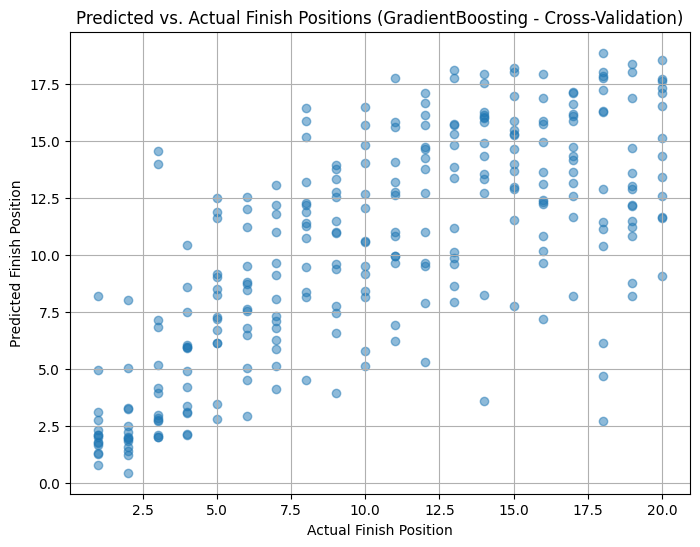

Successfully loaded data for 2025.


In [40]:
# Example call in a notebook with Gradient Boosting model:
race_order, summary = run_prediction_with_fallback(2025, "Hungarian Grand Prix", mode="race-only", n_sims=5000, race_only=False, model_type='GradientBoosting')

In [41]:
# Display the predicted race order and summary
print("\n--- Predicted Race Order ---")
display(race_order)

print("\n--- Simulation Summary ---")
display(summary)


--- Predicted Race Order ---


,Driver,Team,PredFinish
0,Oscar Piastri,McLaren,1.621224
1,Lando Norris,McLaren,1.809527
2,George Russell,Mercedes,4.494696
3,Charles Leclerc,Ferrari,4.937905
4,Max Verstappen,Red Bull Racing,6.609290
5,Gabriel Bortoleto,Kick Sauber,7.412232
6,Fernando Alonso,Aston Martin,7.731403
7,Lance Stroll,Aston Martin,8.440698
8,Lewis Hamilton,Ferrari,8.970182
9,Liam Lawson,Racing Bulls,9.321206



--- Simulation Summary ---


,Driver,Team,AvgPredPos,Win%,Podium%,Points%,ExpPos
0,Franco Colapinto,Alpine,1.608342,38.78,79.42,1851.08,0.0
1,Nico Hulkenberg,Kick Sauber,1.763551,36.50,77.90,1819.12,0.0
2,Lance Stroll,Aston Martin,4.559294,9.66,43.04,1249.10,0.0
3,George Russell,Mercedes,4.883133,8.20,38.50,1177.58,0.0
4,Carlos Sainz,Williams,6.576732,2.62,19.40,840.98,0.0
5,Fernando Alonso,Aston Martin,7.438438,1.38,12.16,684.84,0.0
6,Max Verstappen,Red Bull Racing,7.761308,1.38,10.50,630.68,0.0
7,Isack Hadjar,Racing Bulls,8.400325,0.54,7.30,522.90,0.0
8,Esteban Ocon,Haas F1 Team,8.922933,0.52,5.76,445.98,0.0
9,Alexander Albon,Williams,9.253071,0.36,3.76,400.76,0.0


core           INFO 	Loading data for Australian Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core   

Attempting to load data for year: 2025, up to Grand Prix: Hungarian Grand Prix


core        WARNING 	Fixed incorrect tyre stint information for driver '87'
core        WARNING 	Fixed incorrect tyre stint information for driver '30'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core        WARNING 	Driver 4 completed the race distance 00:00.022000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', '22', '31', '87', '30', '5', '14', '55', '7', '6']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', '22', '31', '87', '30', '5', '14', '55', '7', '6']
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Chinese Grand Prix - Race [v3.6.0]
req            INFO 	Using c


--- Season Aggregated Data ---


,Driver,Team,num_races,mean_finish_pos,median_finish_pos,best_finish_pos,finish_rate,mean_grid_pos,median_grid_pos,form_score,qual_form
0,Alexander Albon,Williams,14,10.428571,9.0,5.0,0.785714,10.285714,10.0,0.095890,0.097222
1,Carlos Sainz,Williams,14,13.142857,13.0,8.0,0.857143,12.000000,12.0,0.076087,0.083333
2,Charles Leclerc,Ferrari,14,6.000000,4.0,2.0,0.928571,5.071429,5.0,0.166667,0.197183
3,Esteban Ocon,Haas F1 Team,14,12.571429,13.0,5.0,0.928571,14.642857,15.0,0.079545,0.068293
4,Fernando Alonso,Aston Martin,14,12.142857,11.0,5.0,0.785714,10.714286,11.5,0.082353,0.093333
5,Franco Colapinto,Alpine,8,16.125000,15.5,13.0,1.000000,15.625000,15.5,0.062016,0.064000
6,Gabriel Bortoleto,Kick Sauber,14,14.428571,15.0,6.0,0.785714,14.285714,15.0,0.069307,0.070000
7,George Russell,Mercedes,14,4.785714,4.5,1.0,1.000000,4.500000,4.0,0.208955,0.222222
8,Isack Hadjar,Racing Bulls,14,12.214286,11.0,6.0,0.857143,10.000000,10.5,0.081871,0.100000
9,Jack Doohan,Alpine,6,16.333333,16.0,13.0,0.666667,15.500000,15.5,0.061224,0.064516



--- Historical Race Data ---


,Driver,Team,GP,Date,Position,Status,finish_ok,grid_pos
0,Lando Norris,McLaren,Australian Grand Prix,2025-03-16 04:00:00,1.0,Finished,1,1.0
1,Max Verstappen,Red Bull Racing,Australian Grand Prix,2025-03-16 04:00:00,2.0,Finished,1,3.0
2,George Russell,Mercedes,Australian Grand Prix,2025-03-16 04:00:00,3.0,Finished,1,4.0
3,Kimi Antonelli,Mercedes,Australian Grand Prix,2025-03-16 04:00:00,4.0,Finished,1,16.0
4,Alexander Albon,Williams,Australian Grand Prix,2025-03-16 04:00:00,5.0,Finished,1,6.0



--- Roster of Drivers for Upcoming Race (Unique Drivers with Latest Team) ---


,Driver,Team
0,Alexander Albon,Williams
1,Carlos Sainz,Williams
2,Charles Leclerc,Ferrari
3,Esteban Ocon,Haas F1 Team
4,Fernando Alonso,Aston Martin
5,Franco Colapinto,Alpine
6,Gabriel Bortoleto,Kick Sauber
7,George Russell,Mercedes
8,Isack Hadjar,Racing Bulls
9,Jack Doohan,Alpine



--- Prediction Frame with Up to Current Features and Latest Team ---


,Driver,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,Team
0,Alexander Albon,14,10.428571,9.0,5.0,0.785714,10.285714,10.0,Williams
1,Carlos Sainz,14,13.142857,13.0,8.0,0.857143,12.000000,12.0,Williams
2,Charles Leclerc,14,6.000000,4.0,2.0,0.928571,5.071429,5.0,Ferrari
3,Esteban Ocon,14,12.571429,13.0,5.0,0.928571,14.642857,15.0,Haas F1 Team
4,Fernando Alonso,14,12.142857,11.0,5.0,0.785714,10.714286,11.5,Aston Martin



--- Prediction Frame after Merging form_score and qual_form ---


,Driver,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,Team,form_score,qual_form
0,Alexander Albon,14,10.428571,9.0,5.0,0.785714,10.285714,10.0,Williams,0.095890,0.097222
1,Carlos Sainz,14,13.142857,13.0,8.0,0.857143,12.000000,12.0,Williams,0.076087,0.083333
2,Charles Leclerc,14,6.000000,4.0,2.0,0.928571,5.071429,5.0,Ferrari,0.166667,0.197183
3,Esteban Ocon,14,12.571429,13.0,5.0,0.928571,14.642857,15.0,Haas F1 Team,0.079545,0.068293
4,Fernando Alonso,14,12.142857,11.0,5.0,0.785714,10.714286,11.5,Aston Martin,0.082353,0.093333
5,Franco Colapinto,8,16.125000,15.5,13.0,1.000000,15.625000,15.5,Alpine,0.062016,0.064000
6,Gabriel Bortoleto,14,14.428571,15.0,6.0,0.785714,14.285714,15.0,Kick Sauber,0.069307,0.070000
7,George Russell,14,4.785714,4.5,1.0,1.000000,4.500000,4.0,Mercedes,0.208955,0.222222
8,Isack Hadjar,14,12.214286,11.0,6.0,0.857143,10.000000,10.5,Racing Bulls,0.081871,0.100000
9,Jack Doohan,6,16.333333,16.0,13.0,0.666667,15.500000,15.5,Alpine,0.061224,0.064516



--- Initial Training Data ---


,Driver,Team,GP,y_finish_pos,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current
0,Alexander Albon,Williams,Australian Grand Prix,5.0,1,5.000000,5.0,5.0,1.000000,6.000000,6.0
1,Alexander Albon,Williams,Chinese Grand Prix,7.0,2,6.000000,6.0,5.0,1.000000,8.000000,8.0
2,Alexander Albon,Williams,Japanese Grand Prix,9.0,3,7.000000,7.0,5.0,1.000000,8.333333,9.0
3,Alexander Albon,Williams,Bahrain Grand Prix,12.0,4,8.250000,8.0,5.0,1.000000,10.000000,9.5
4,Alexander Albon,Williams,Saudi Arabian Grand Prix,9.0,5,8.400000,9.0,5.0,1.000000,10.200000,10.0
...,...,...,...,...,...,...,...,...,...,...,...
274,Yuki Tsunoda,Red Bull Racing,Canadian Grand Prix,12.0,10,13.000000,12.0,9.0,0.900000,12.500000,11.0
275,Yuki Tsunoda,Red Bull Racing,Austrian Grand Prix,16.0,11,13.272727,12.0,9.0,0.909091,13.000000,12.0
276,Yuki Tsunoda,Red Bull Racing,British Grand Prix,15.0,12,13.416667,12.5,9.0,0.916667,12.833333,11.5
277,Yuki Tsunoda,Red Bull Racing,Belgian Grand Prix,13.0,13,13.384615,13.0,9.0,0.923077,12.384615,11.0



--- Training Data after Merging form_score ---


,Driver,Team,GP,y_finish_pos,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,form_score
0,Alexander Albon,Williams,Australian Grand Prix,5.0,1,5.00,5.0,5.0,1.0,6.000000,6.0,0.09589
1,Alexander Albon,Williams,Chinese Grand Prix,7.0,2,6.00,6.0,5.0,1.0,8.000000,8.0,0.09589
2,Alexander Albon,Williams,Japanese Grand Prix,9.0,3,7.00,7.0,5.0,1.0,8.333333,9.0,0.09589
3,Alexander Albon,Williams,Bahrain Grand Prix,12.0,4,8.25,8.0,5.0,1.0,10.000000,9.5,0.09589
4,Alexander Albon,Williams,Saudi Arabian Grand Prix,9.0,5,8.40,9.0,5.0,1.0,10.200000,10.0,0.09589



--- Final Training Data (after dropping NaNs in y_finish_pos) ---


,Driver,Team,GP,y_finish_pos,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,form_score
0,Alexander Albon,Williams,Australian Grand Prix,5.0,1,5.00,5.0,5.0,1.0,0.09589
1,Alexander Albon,Williams,Chinese Grand Prix,7.0,2,6.00,6.0,5.0,1.0,0.09589
2,Alexander Albon,Williams,Japanese Grand Prix,9.0,3,7.00,7.0,5.0,1.0,0.09589
3,Alexander Albon,Williams,Bahrain Grand Prix,12.0,4,8.25,8.0,5.0,1.0,0.09589
4,Alexander Albon,Williams,Saudi Arabian Grand Prix,9.0,5,8.40,9.0,5.0,1.0,0.09589



--- Feature columns for training ---
Index(['num_races', 'mean_finish_up_to_current', 'median_finish_up_to_current',
       'best_finish_up_to_current', 'finish_rate_up_to_current', 'form_score',
       'form_score'],
      dtype='object')
CV MAE (RandomForest): 2.913 positions
CV RMSE (RandomForest): 3.841 positions
CV R-squared (RandomForest): 0.553


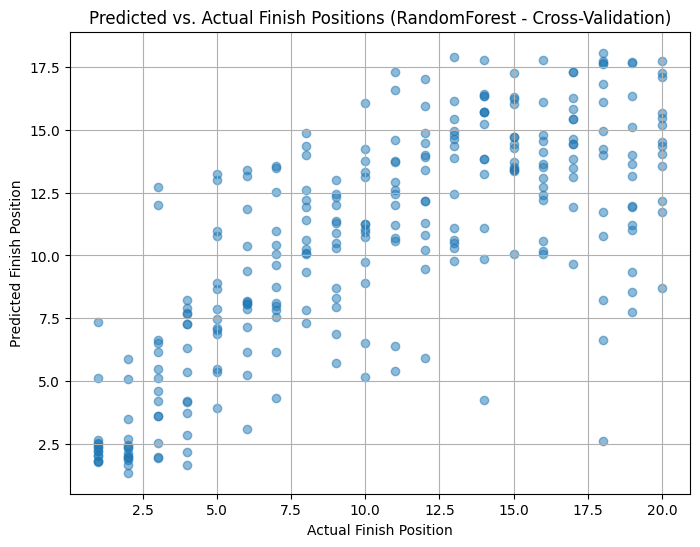

Successfully loaded data for 2025.


In [42]:
# Run the prediction process with Random Forest model
race_order_rf, summary_rf = run_prediction_with_fallback(2025, "Hungarian Grand Prix", mode="race-only", n_sims=5000, race_only=False, model_type='RandomForest')

In [43]:
# Display the predicted race order and summary for Random Forest
print("\n--- Predicted Race Order (Random Forest) ---")
display(race_order_rf)

print("\n--- Simulation Summary (Random Forest) ---")
display(summary_rf)


--- Predicted Race Order (Random Forest) ---


,Driver,Team,PredFinish
0,Lando Norris,McLaren,1.529968
1,Oscar Piastri,McLaren,1.926742
2,Charles Leclerc,Ferrari,5.676463
3,George Russell,Mercedes,5.900855
4,Max Verstappen,Red Bull Racing,6.899738
5,Lewis Hamilton,Ferrari,7.836701
6,Liam Lawson,Racing Bulls,9.617305
7,Fernando Alonso,Aston Martin,10.419768
8,Lance Stroll,Aston Martin,10.798526
9,Nico Hulkenberg,Kick Sauber,11.677465



--- Simulation Summary (Random Forest) ---


,Driver,Team,AvgPredPos,Win%,Podium%,Points%,ExpPos
0,Isack Hadjar,Racing Bulls,1.568734,44.48,88.04,1980.12,0.0
1,Oliver Bearman,Haas F1 Team,1.905367,39.96,86.14,1926.80,0.0
2,Charles Leclerc,Ferrari,5.623490,5.34,39.80,1193.70,0.0
3,Fernando Alonso,Aston Martin,5.874044,5.20,35.06,1148.74,0.0
4,Pierre Gasly,Alpine,6.885579,2.98,23.22,953.28,0.0
5,Alexander Albon,Williams,7.796852,1.20,13.92,778.24,0.0
6,Esteban Ocon,Haas F1 Team,9.562655,0.30,5.38,484.58,0.0
7,Max Verstappen,Red Bull Racing,10.417865,0.18,2.66,359.08,0.0
8,Kimi Antonelli,Mercedes,10.750392,0.18,2.04,312.72,0.0
9,Yuki Tsunoda,Red Bull Racing,11.655865,0.04,1.16,214.48,0.0
